## **Yvan CARRE**

## Assignment 2 : Computer Vision

# Import

In [1]:
import tensorflow as tf
from tensorflow.keras.models import save_model
import tensorflow.keras.layers as L

import numpy as np
from sklearn.model_selection import train_test_split
import os

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model

import seaborn as sns
import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
import cv2
import scipy.misc
import tensorflow.keras as k

from tensorflow.keras.regularizers import l2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K

import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K

# Helper function

In [2]:
def visualize_samples(images, num_samples=4):
    plt.figure(figsize=(7, 7))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.clip(images[i] , 0, 1))
        plt.axis('off')
    plt.show()

def plot_loss_and_accuracy(history):
    plt.subplots(1, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss',  linewidth=2)
    plt.title('Model Loss During Training')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def load_images(file_list, dataset_path):
    images = []
    for image_file in file_list:
        image_path = os.path.join(dataset_path, image_file)
        image = Image.open(image_path)
        image_array = np.array(image)
        images.append(image_array)
    return np.array(images)


def show_results(noisy_imgs, denoised_imgs, original_imgs, n=5):
    plt.figure()
    for i in range(n):

        ax = plt.subplot(3, n, i + 1)
        plt.imshow(np.clip(original_imgs[i] , 0, 1))
        plt.title('Original')
        plt.axis('off')

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(np.clip(noisy_imgs[i] , 0, 1))
        plt.title('Noisy')
        plt.axis('off')

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(np.clip(denoised_imgs[i] , 0, 1))
        plt.title('Denoisy')
        plt.axis('off')

    plt.show()

def apply_gaussian_noise(X,sigma=0.1):
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise


# --------------------  part 3 ---------------- helper


def embed_images(model, images):
    return model.predict(images)

def compute_map(query_embeddings, test_embeddings, query_labels, test_labels):
    average_precisions = []

    for query_idx in range(len(query_embeddings)):
        query_embedding = query_embeddings[query_idx]
        query_label = query_labels[query_idx]

        distances = np.linalg.norm(test_embeddings - query_embedding, axis=1)
        sorted_indices = np.argsort(distances)
        sorted_labels = test_labels[sorted_indices]

        correct_matches = (sorted_labels == query_label)
        num_correct = np.sum(correct_matches)
        precision_at_k = np.cumsum(correct_matches) / (np.arange(len(correct_matches)) + 1)

        if num_correct > 0:
            average_precision = np.sum(precision_at_k * correct_matches) / num_correct
            average_precisions.append(average_precision)

    return np.mean(average_precisions)


def get_top_k_closest_images(query_embedding, test_embeddings, test_images, k=5):
    distances = np.linalg.norm(test_embeddings - query_embedding, axis=1)
    top_k_indices = np.argsort(distances)[:k]
    return test_images[top_k_indices], distances[top_k_indices]

def plot_top_k_images(query_image, top_k_images, top_k_distances):
    plt.figure(figsize=(15, 5))

    # ensure the query image is in the correct format
    query_image_uint8 = (query_image * 255).astype(np.uint8) if query_image.dtype == np.float64 else query_image

    plt.subplot(1, 6, 1)
    plt.imshow(cv2.cvtColor(query_image_uint8, cv2.COLOR_BGR2RGB))
    plt.title("Query Image")
    plt.axis('off')

    for i in range(len(top_k_images)):
        top_k_image_uint8 = (top_k_images[i] * 255).astype(np.uint8) if top_k_images[i].dtype == np.float64 else top_k_images[i]
        plt.subplot(1, 6, i + 2)
        plt.imshow(cv2.cvtColor(top_k_image_uint8, cv2.COLOR_BGR2RGB))
        plt.title(f"Rank {i+1}\nDist: {top_k_distances[i]:.2f}")
        plt.axis('off')

    plt.show()

def load_images_and_labels(folder):
    images = []
    labels = []
    for img_path in glob.glob(os.path.join(folder, '*.jpg')):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        img = img / 255.0
        images.append(img)
        label = int(img_path.split('/')[-1].split('_')[0])
        labels.append(label)
    return np.array(images), np.array(labels)

# Fully convolutional networks for image denoising

- **Download and Load Dataset:**
Download the LFWcrop dataset and load it into your environment. Split the images into training, validation, and test sets.

- **Add Gaussian Noise:**
Add zero-mean Gaussian noise with a standard deviation of 10% of the maximum possible pixel value to the images to create the noisy inputs.

- **Design the Network Architecture:**
Design a fully convolutional network with an encoder-decoder structure. The encoder will consist of convolutional and pooling layers, and the decoder will use upsampling layers to reconstruct the denoised images.

- **Specify the Loss Function:**
Use the Mean Squared Error (MSE) loss function to measure the difference between the denoised output and the original clean image.

- **Train the Model:**
Train the model using the training set, validate it on the validation set, and evaluate its performance on the test set.

- **Evaluate and Discuss Performance:**
Visualize the performance of the model on a few noisy test images and discuss the results.

## Download data

In [3]:
!wget https://conradsanderson.id.au/lfwcrop/lfwcrop_color.zip
!unzip lfwcrop_color.zip

--2024-06-01 15:32:27--  https://conradsanderson.id.au/lfwcrop/lfwcrop_color.zip
Resolving conradsanderson.id.au (conradsanderson.id.au)... 43.250.142.19, 2400:b800:3:1::1a
Connecting to conradsanderson.id.au (conradsanderson.id.au)|43.250.142.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152404390 (145M) [application/zip]
Saving to: ‘lfwcrop_color.zip.3’

lfwcrop_color.zip.3 100%[===================>] 145.34M  9.99MB/s    in 17s     

2024-06-01 15:32:46 (8.78 MB/s) - ‘lfwcrop_color.zip.3’ saved [152404390/152404390]

Archive:  lfwcrop_color.zip
replace lfwcrop_color/lists/07_test_same.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Load and visualize data

In [3]:
# Load dataset and the dataset
dataset_path = '/content/lfwcrop_color/faces'
image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

#
X_train = load_images(train_files, dataset_path)
X_val = load_images(val_files, dataset_path)
X_test = load_images(test_files, dataset_path)

## Normalize the dataset
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

print('Train shape',X_train.shape)
print('Val shape',X_val.shape)
print('Test shape',X_test.shape)

Train shape (9527, 64, 64, 3)
Val shape (1059, 64, 64, 3)
Test shape (2647, 64, 64, 3)


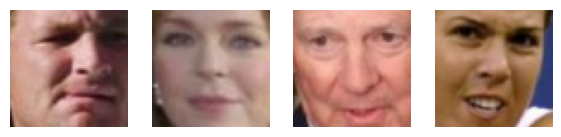

In [4]:
visualize_samples(X_train)

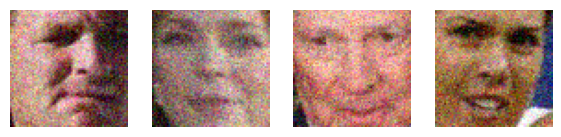

In [5]:
# VIsualize image with noise
visualize_samples(apply_gaussian_noise(X_train,sigma=0.1))

## Model - Architecture (Descripotion)
Design a fully convolutional network with an encoder-decoder structure.

The encoder will consist of convolutional and pooling layers, and the decoder will use upsampling layers to reconstruct the denoised images.

More precisely, our autoencoder is a convolutional neural network with : an encoder that compresses 64x64 RGB images into an 8x8x256 representation, and a decoder that reconstructs the images back to their original size. It uses Conv2D, MaxPooling2D, and UpSampling2D layers, with ReLU activations in hidden layers and a sigmoid activation in the output layer also the model is optimized using the Adam optimizer and mean squared error loss.


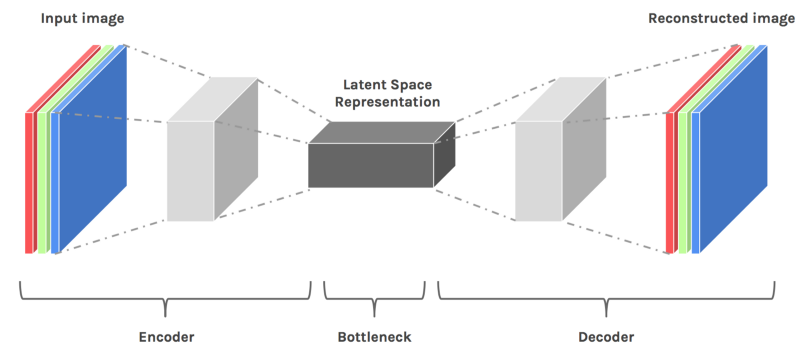

In [6]:
## Apply noisy function to get noisy dataset
sigma=0.1
X_train_noisy= apply_gaussian_noise(X_train,sigma)
X_val_noisy = apply_gaussian_noise(X_val,sigma)
X_test_noisy = apply_gaussian_noise(X_test,sigma)

In [7]:
def autoencoder_model(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

input_shape = (64, 64, 3)
model = autoencoder_model(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
history=model.fit(X_train_noisy, X_train,
                epochs=20,
                shuffle=True,
                callbacks=[early_stopping,lr_reduction],
                validation_data=(X_val_noisy, X_val),verbose=1)

Epoch 1/20
298/298 [==============================] - 13s 26ms/step - loss: 0.0083 - val_loss: 0.0044 - lr: 0.0010
Epoch 2/20
298/298 [==============================] - 6s 20ms/step - loss: 0.0029 - val_loss: 0.0025 - lr: 0.0010
Epoch 3/20
298/298 [==============================] - 6s 20ms/step - loss: 0.0022 - val_loss: 0.0020 - lr: 0.0010
Epoch 4/20
298/298 [==============================] - 6s 20ms/step - loss: 0.0018 - val_loss: 0.0016 - lr: 0.0010
Epoch 5/20
298/298 [==============================] - 6s 20ms/step - loss: 0.0016 - val_loss: 0.0016 - lr: 0.0010
Epoch 6/20
298/298 [==============================] - 6s 21ms/step - loss: 0.0015 - val_loss: 0.0014 - lr: 0.0010
Epoch 7/20
298/298 [==============================] - 6s 21ms/step - loss: 0.0015 - val_loss: 0.0013 - lr: 0.0010
Epoch 8/20
298/298 [==============================] - 6s 20ms/step - loss: 0.0014 - val_loss: 0.0014 - lr: 0.0010
Epoch 9/20
298/298 [==============================] - ETA: 0s - loss: 0.0013
Epoch 9: R

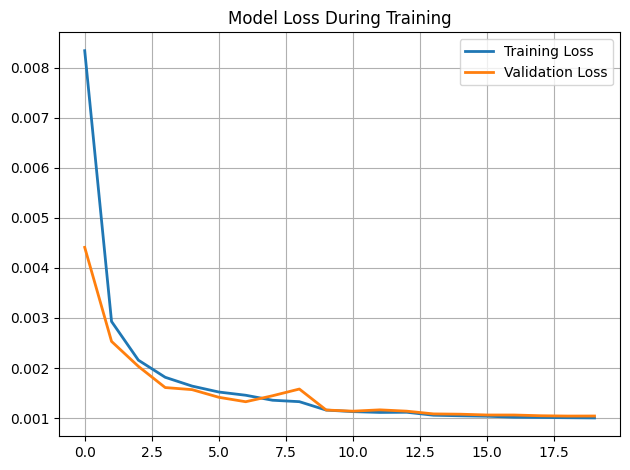

In [9]:
## Visualisation of the training curve
plot_loss_and_accuracy(history)

## Evaluation and discussion

83/83 [==============================] - 1s 8ms/step - loss: 0.0010
Test Loss: 0.0010465886443853378
83/83 [==============================] - 1s 6ms/step


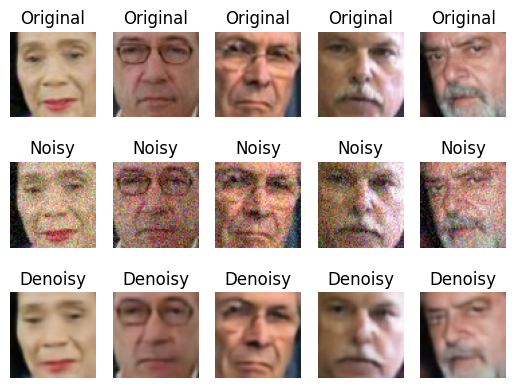

In [10]:
# Evaluate the model on test set
test_loss = model.evaluate(X_test_noisy, X_test)
print('Test Loss:', test_loss)

# Show results
denoised_test_imgs = model.predict(X_test_noisy)
show_results(X_test_noisy, denoised_test_imgs, X_test)

The model performance on the noisy test images can be evaluated based on the visual quality of the denoised images and the quantitative test loss (MSE). The denoised images appear cleaner with less visible noise compared to the noisy inputs, and they closely resemble the original clean images. .

As we can the quality is very good and the test loss is very small **1 e-03**

# 2. Training a small image captioning model


### a) The Model Uses Word2Vec
**What is Word2Vec?**

**Word2Vec** is a technique for natural language processing that creates word embeddings. It transforms words into continuous vector space representations, where semantically similar words are mapped to proximate points in that space. Word2Vec models can be trained using either the Continuous Bag of Words (CBOW) or the Skip-gram approach:
- **CBOW** predicts the target word from surrounding context words.
- **Skip-gram** predicts the surrounding context words given the target word.

**Where, How, and Why is it Used in This Model?**

In the image captioning model, Word2Vec is used to convert words in the captions into vector representations. This happens as follows:
- **Where:** Word2Vec is applied to the text data, specifically the captions associated with the images.
- **How:** During preprocessing, each word in the captions is converted into its corresponding word vector using a pre-trained Word2Vec model or by training a Word2Vec model on the caption data.
- **Why:** Using Word2Vec embeddings helps the model understand the semantic relationships between words, improving the quality of the generated captions. These embeddings are fed into the neural network to provide a more meaningful representation of the input words compared to one-hot encoding.


### b) Loss Function

**Description and Explanation:**

The loss function used for training the image captioning model is the **categorical cross-entropy loss**. This function is appropriate for multi-class classification problems where each input can belong to one out of many classes.

**How it Works:**
1. **Prediction:** For each word in the sequence (caption), the model predicts the probability distribution over the vocabulary.
2. **Comparison:** The predicted probability distribution is compared to the actual word (one-hot encoded) in the training sequence.
3. **Calculation:** The categorical cross-entropy loss is calculated as:
   $
   L = -\sum_{i=1}^{N} y_i \log(\hat{y}_i)
   $
   where $ y_i $ is the actual word (one-hot encoded), $ \hat{y}_i $ is the predicted probability, and $N $ is the total number of words in the vocabulary.

The goal is to minimize this loss, thus making the predicted probabilities as close to the actual distribution as possible.





### c) BLEU Score
**What is a BLEU Score?**

**BLEU (Bilingual Evaluation Understudy)** score is a metric for evaluating the quality of text generated by a model, such as machine translations or image captions, compared to one or more reference texts.

**How it is Calculated:**
1. **N-gram Precision:** Calculate the precision for various n-grams (typically unigrams, bigrams, trigrams, and 4-grams). Precision is the fraction of n-grams in the generated text that appear in the reference texts.
2. **Brevity Penalty:** Apply a penalty for generated captions that are shorter than the reference captions to discourage overly short outputs.
3. **Score Calculation:**
   $
   \text{BLEU} = \text{Brevity Penalty} \times \exp \left( \sum_{n=1}^{N} w_n \log p_n \right)
   $
   where $ p_n $ is the precision for n-grams and $ w_n $ are the weights (often equally weighted).

**Sufficiency as a Measure:**

While BLEU scores provide a quantitative measure of how closely the generated captions match the reference captions, they have some limitations:

- **Simplicity:** BLEU focuses on exact matches of n-grams, potentially missing out on semantic similarities.
- **Context Ignorance:** It does not consider the overall context or fluency of the generated text.
- **Reference Dependence:** The score heavily relies on the quality and variety of the reference texts.

Therefore, while BLEU is useful for a quick, objective measure, it may not fully capture the qualitative aspects of generated captions. Complementing BLEU with human evaluations or additional metrics like **METEOR** or **CIDEr** can provide a more comprehensive assessment of caption quality.

# 3. Image retrieval for vehicle re-identification

## Download the dataset

In [ ]:
import gdown
import zipfile

# Download the dataset
url = 'https://drive.google.com/uc?id=1M-t2LBkKa0-J9SlsYZgHNI2MPkhOSmGm'
output = 'VeRi.zip'
gdown.download(url, output, quiet=False)

# Extract the dataset
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('VeRi')

In [3]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

## Data Preprocessing

Load the training images and their corresponding vehicle ID labels. Preprocess these images by resizing them to a consistent size and normalizing the pixel values. This step ensures that the images are in a suitable format for input into the neural network.

In [4]:
# Load data for training and val
train_images, train_labels = load_images_and_labels('/content/VeRi/VeRi/image_train')
val_images, val_labels = load_images_and_labels('/content/VeRi/VeRi/image_test')

## Model

- **Triplet Generation:** We create triplets of images for training the network. Each triplet consists of an anchor image, a positive image (from the same vehicle as the anchor), and a negative image (from a different vehicle).

- **Embedding Network Design:** We design a Convolutional Neural Network (CNN) architecture to extract feature embeddings from the images. This network typically consists of several convolutional layers followed by pooling layers to reduce spatial dimensions, and dense layers to learn the final embedding space.(512 in our case)

- **Triplet Loss Function:** We implement the triplet loss function, which ensures that the distance between the anchor and positive embeddings is minimized, while the distance between the anchor and negative embeddings is maximized. Use the Euclidean distance metric to compute these distances and incorporate a margin parameter to control the embedding space.

- **Model Creation:** We construct a model that takes triplets of images as input and outputs their embeddings.

In [5]:
def generate_triplets(images, labels, batch_size):
    def create_triplet(anchor, positive, negative):
        return (images[anchor], images[positive], images[negative])

    while True:
        anchor_images = []
        positive_images = []
        negative_images = []

        for _ in range(batch_size):
            anchor_idx = np.random.randint(0, len(images))
            positive_idx = np.random.choice(np.where(labels == labels[anchor_idx])[0])
            negative_idx = np.random.choice(np.where(labels != labels[anchor_idx])[0])
            anchor_img, positive_img, negative_img = create_triplet(anchor_idx, positive_idx, negative_idx)
            anchor_images.append(anchor_img)
            positive_images.append(positive_img)
            negative_images.append(negative_img)

        yield [np.array(anchor_images), np.array(positive_images), np.array(negative_images)], np.zeros((batch_size, 3))

# Embedding network
def create_embedding_network(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    #x = Dropout(0.1)(x)
    output = Dense(128, activation='relu')(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

#  triplet loss function
def triplet_loss(y_true, y_pred, alpha=0.5):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + alpha, 0)
    return loss

# Create model
def create_model(embedding_network, input_shape):
    anchor_input = Input(shape=input_shape, name='anchor_input')
    positive_input = Input(shape=input_shape, name='positive_input')
    negative_input = Input(shape=input_shape, name='negative_input')

    encoded_anchor = embedding_network(anchor_input)
    encoded_positive = embedding_network(positive_input)
    encoded_negative = embedding_network(negative_input)

    merged_vector = Lambda(lambda x: K.stack([x[0], x[1], x[2]], axis=1))([encoded_anchor, encoded_positive, encoded_negative])
    model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)

    model.compile(optimizer=Adam(0.001), loss=triplet_loss)
    return model

## Training

In [6]:
input_shape=(64,64,3)
embedding_network = create_embedding_network(input_shape)
model = create_model(embedding_network,input_shape)
# Batch size
batch_size = 300
# Generate data
train_generator = generate_triplets(train_images, train_labels, batch_size)
val_generator = generate_triplets(val_images, val_labels, batch_size)
# Fit the model
history=model.fit(train_generator, steps_per_epoch=len(train_images) // batch_size, epochs=40,
          validation_data=val_generator, validation_steps=len(val_images) // batch_size, callbacks=[lr_reduction,early_stopping])

Epoch 1/40
125/125 [==============================] - 22s 119ms/step - loss: 0.1725 - val_loss: 0.1236 - lr: 0.0010
Epoch 2/40
125/125 [==============================] - 14s 112ms/step - loss: 0.0951 - val_loss: 0.1044 - lr: 0.0010
Epoch 3/40
125/125 [==============================] - 14s 113ms/step - loss: 0.0817 - val_loss: 0.1049 - lr: 0.0010
Epoch 4/40
125/125 [==============================] - 14s 113ms/step - loss: 0.0720 - val_loss: 0.0945 - lr: 0.0010
Epoch 5/40
125/125 [==============================] - 14s 113ms/step - loss: 0.0661 - val_loss: 0.0839 - lr: 0.0010
Epoch 6/40
125/125 [==============================] - 14s 114ms/step - loss: 0.0630 - val_loss: 0.0877 - lr: 0.0010
Epoch 7/40
125/125 [==============================] - ETA: 0s - loss: 0.0573
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
125/125 [==============================] - 14s 114ms/step - loss: 0.0573 - val_loss: 0.0909 - lr: 0.0010
Epoch 8/40
125/125 [==========================

## Evaluation

- **Embedding Generation:** We use this to generate embeddings for all images in the query and test sets. We pass each image through the embedding network to obtain its feature vector.

- **Image Retrieval:** For each query image, we calculate the Euclidean distances between its embedding and the embeddings of all test images. Rank the test images based on these distances, with the smallest distance indicating the most similar images.

- **Evaluation:** We evaluate the retrieval performance using Mean Average Precision (mAP). We compute the average precision for each query image based on the ranked list of test images, and then average these precision values over all queries to obtain the mAP score.

In [10]:
output_dir = "/content/VeRi/VeRi/"
query_images, _ = load_images_and_labels(os.path.join(output_dir, 'image_query'))
test_images, test_labels = load_images_and_labels(os.path.join(output_dir, 'image_test'))

query_embeddings = embed_images(embedding_network, query_images)
test_embeddings = embed_images(embedding_network, test_images)


query_labels = np.array([int(img_path.split('/')[-1].split('_')[0]) for img_path in glob.glob(os.path.join(output_dir, 'image_query', '*.jpg'))])
test_labels = np.array([int(img_path.split('/')[-1].split('_')[0]) for img_path in glob.glob(os.path.join(output_dir, 'image_test', '*.jpg'))])

mAP = compute_map(query_embeddings, test_embeddings, query_labels, test_labels)
print("Mean Average Precision (mAP):", mAP)

53/53 [==============================] - 0s 2ms/step
Mean Average Precision (mAP): 0.40381758523108496


## Visual Inspection

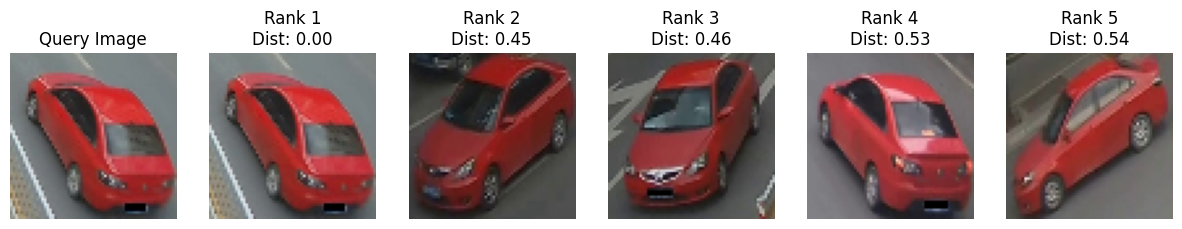

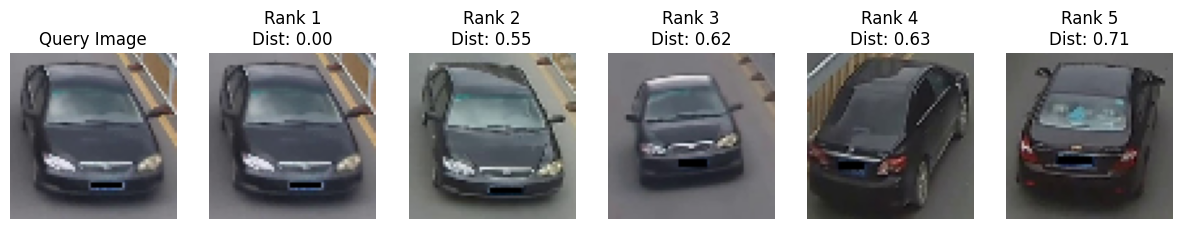

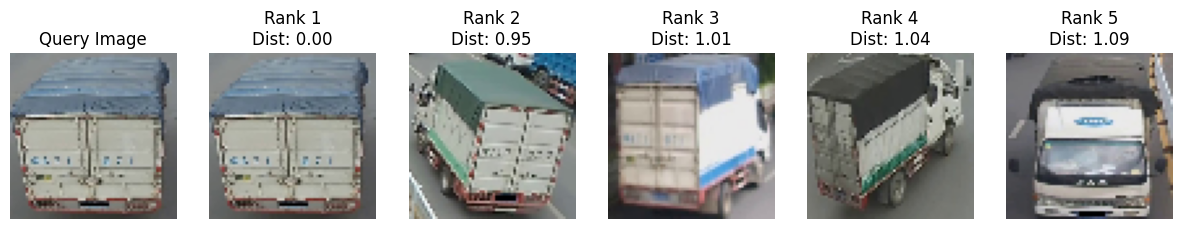

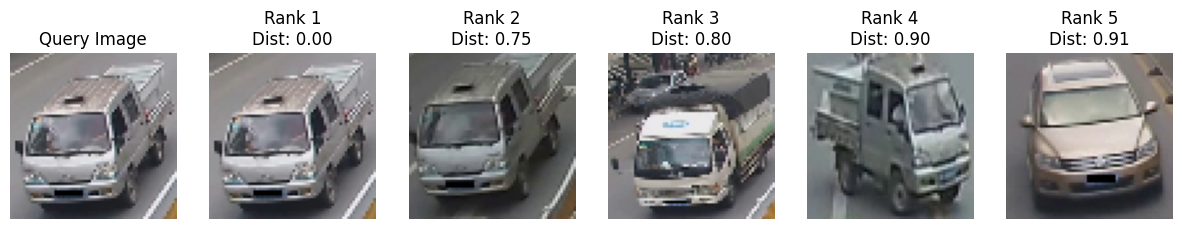

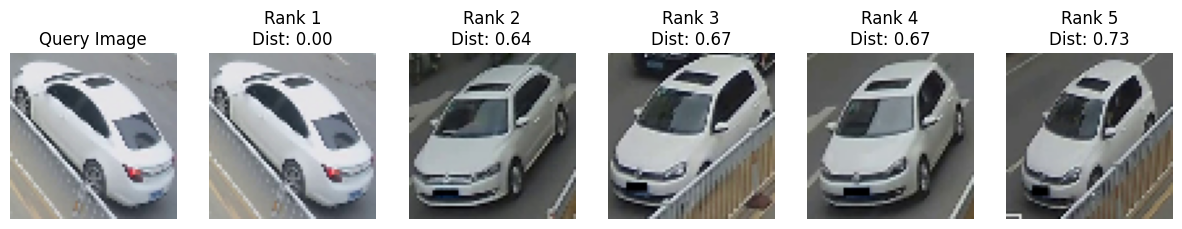

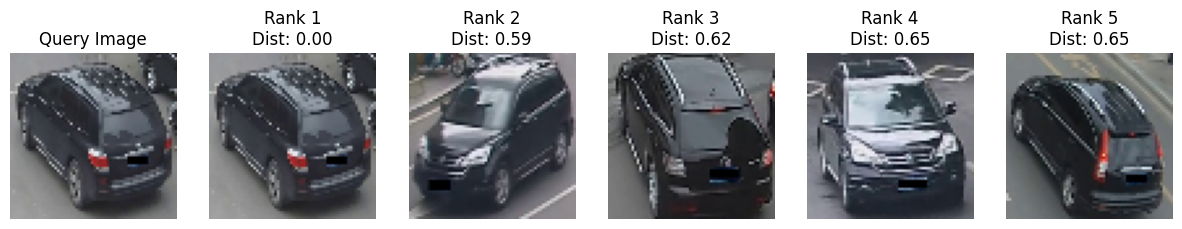

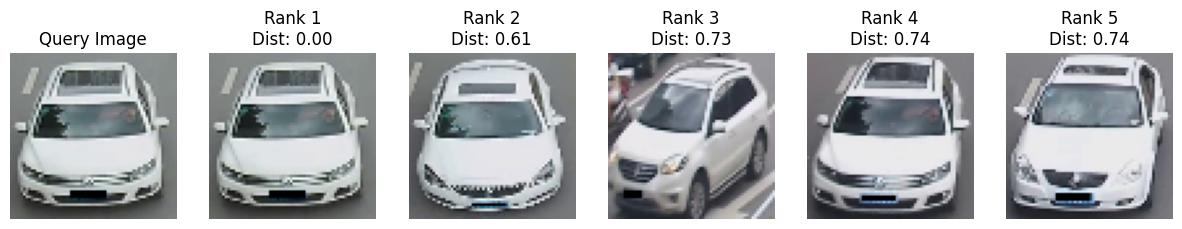

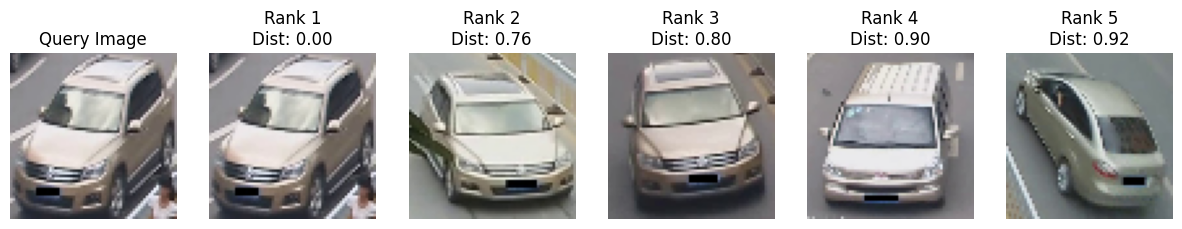

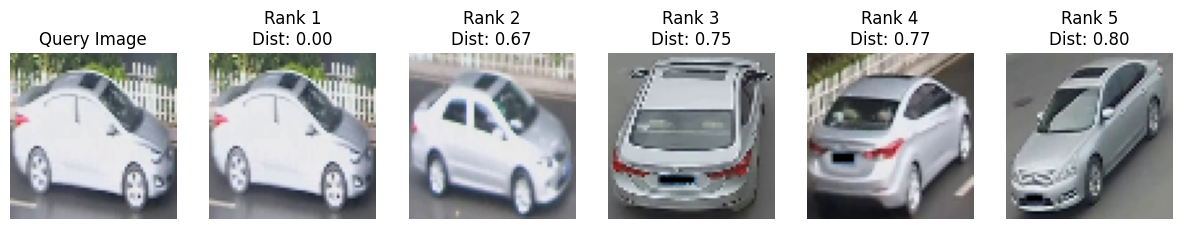

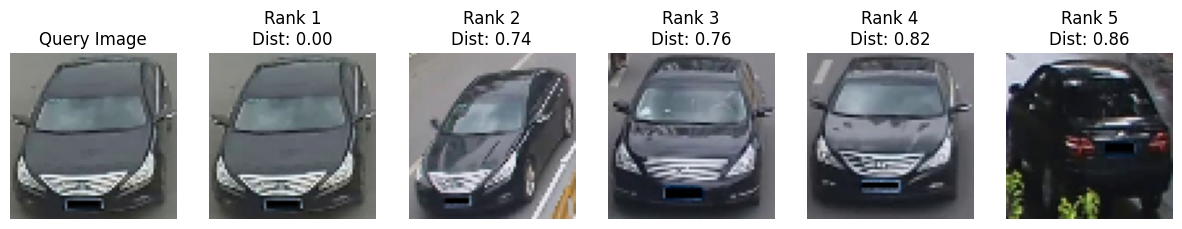

In [14]:
num_queries_to_inspect = 10
for query_idx in range(num_queries_to_inspect):
    query_image = query_images[query_idx]
    query_embedding = query_embeddings[query_idx]
    top_k_images, top_k_distances = get_top_k_closest_images(query_embedding, test_embeddings, test_images)
    plot_top_k_images(query_image, top_k_images, top_k_distances)

Least the distance is small more they are closed

## Discussion


### Discussion

- In this part, we focused on creating an image retrieval system for vehicle re-identification using the VeRi dataset. Despite implementing a Convolutional Neural Network (CNN) from scratch, the system yielded a mean Average Precision (mAP) of $40\%$, with visualizations that were satisfactory but indicated room for improvement.

- The primary challenges faced during this project were setting up an effective model architecture and fine-tuning various parameters, particularly the margin size ($\alpha$) for the triplet loss function. Adjusting $\alpha$ and other hyperparameters required careful experimentation to strike a balance between underfitting and overfitting. Additionally, determining the optimal mini-batch size and selecting an appropriate triplet mining strategy were crucial steps that significantly influenced the training process and the overall performance of the model.

- Despite these efforts, the current results suggest that the performance can be further enhanced. To improve our image retrieval system, we plan to leverage pretrained CNNs. Using pretrained models as feature extractors can provide a robust starting point, as these models have already learned useful features from large and diverse datasets. By fine-tuning the pretrained models on the VeRi dataset, we expect to achieve better generalization and higher performance.

So, while building a CNN from scratch provided valuable insights into the complexities of model design and parameter optimization, the next logical step involves utilizing pretrained models. This approach is anticipated to significantly boost the accuracy and effectiveness of our vehicle re-identification system, surpassing the current mAP of 30% and leading to more reliable retrieval results.